# ARMA Primer

In this notebooks, I try to give practical examples of fitting ARMA models to some time series.  The point is to demonstrate the usage of the statsmodels package for this, and to motivate the use of ARMA techniques for prewhitening of MT data.  

The notebooks have two parts:

### Part 1:
Contrived examples of random timeseries (geneated from a seed) are filtered so that they have "shaped" or "non-white" spectra, resulting in "starting data".

The statsmodels package is used to fit various orders of AR and MA models to these data and the spectra of the residuals are checked to be apporximately flat.  A check is also applied to confirm that a filtered version of the residuals results in the original shaped noise time series.


### Part 2:
Fourier transform comparisons: 
FFT is performed in two ways.  First the data are directly FFT-ed and second, the whitened residuals of the starting model are FFT-ed and corrected in spectral domain for the ARMA filter.  

Spectra are compared --- we expect the spectra to be highly similar, but with less leakage in the second case.

There remains one bothersome question after all this.  The ARMA PW process effectively separates the time series into a sum of a whitened series and an ARMA filter.  The question is why is there less spectral leakage when the Filter is z-transformed (and evaluated at jw) than when it's effect is left in the time series?  

## Definitions

Recall that a **Moving Average** (MA) process is y(t) such that:

$y(t) = 
\mu + 
\epsilon_t - 
\theta_1  \epsilon_{t-1} -
\theta_2  \epsilon_{t-2} -
...
\theta_q  \epsilon_{t-q}
$

with 
$\epsilon_t ~ WN(0,\sigma^2)$

And an **Auto Regressive** (AR) process is y(t) such that:

$y(t) = 
\mu + 
\phi_1  y_{t-1} +
\phi_2  y_{t-2} +
...
\phi_q  y_{t-2} +
\epsilon_t
$

again with 
$\epsilon_t ~ WN(0,\sigma^2)$



And an **ARMA** process is y(t) such that:

$y(t) = 
\mu + 
\phi_1  y_{t-1} +
\phi_2  y_{t-2} +
... +
\phi_q  y_{t-2} +
\epsilon_t -
\theta_1  \epsilon_{t-1} -
\theta_2  \epsilon_{t-2} -
... -
\theta_q  \epsilon_{t-q}
$



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import scipy.signal as ssig

from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Uncomment the following line to make plots interactive.
%matplotlib widget

In [3]:
### Seed the random number generator for reproducability

In [4]:
seed = 1
np.random.seed(seed)

### Define helper functions:

In [5]:
def compare_real_and_imaginary(data1, data2, label1="", label2="", symbol1='-',
                               symbol2='-'):
    fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
    axs[0].plot(np.real(data1), label=label1)
    axs[0].plot(np.real(data2),  label=label2)
    axs[0].legend()
    axs[0].set_title("Real")

    axs[1].plot(np.imag(data1), label=label1)
    axs[1].plot(np.imag(data2),  label=label2)
    axs[1].legend()
    axs[1].set_title("Imaginary")
    # plt.show()
    pass

## Define an ARMA "Shaping Filter"

There are four pre-made cases here.  Note that I create the "shaped noise" via an ARMA process, and then select to fit an arma model to explain the difference between the shaped noise and stationary noise that has the same order as shaping filter. This is not necessary, we could use an arbitrary ARMA order to fit shaped noise.

In [6]:
case_id = 4

if case_id == 1:
    shaping_ma = 0.5*np.array([1, -1]) #define an MA filter to shape the noise
    shaping_ar = [1] # define an AR Filter ... its a little complicated, but when this is [1] there is actually no AR component
elif case_id ==2:
    shaping_ma = [0.25, 0.5, 0.25]
    shaping_ar = [1]
elif case_id == 3:
    shaping_ma = [0.25, 0.5, 0.25]
    shaping_ar = [1, 0.9]
elif case_id == 4:
    shaping_ma = [0.25, 0.5, 0.25]
    shaping_ar = [0.9, 0.8, 0.3]

# This is somewhat arbitrary
ar_order = len(shaping_ar) - 1
ma_order = len(shaping_ma)


## Shape some noise

Make a noise time series.  Then shape its spectrum by applying a known ARMA filter.  Then, fit an ARMA model of the same order as the shaping filter.

Use this toy example to get a feel for the ARMA coefficents and how they prewhiten

In [7]:
N = 1024*2 # Number of points in the time series
noise = np.random.random(N) # Uniform random noise of order N
#noise = np.random.randn(N) #Gaussian Noise of order N
noise -= np.mean(noise) # Remove the mean 

shaped_noise = ssig.lfilter(shaping_ma, shaping_ar, noise)
shaped_noise -= np.mean(shaped_noise)

noise_spec = np.fft.fft(noise)
shaped_noise_spec = np.fft.fft(shaped_noise)

Text(0, 0.5, 'Amplitude')

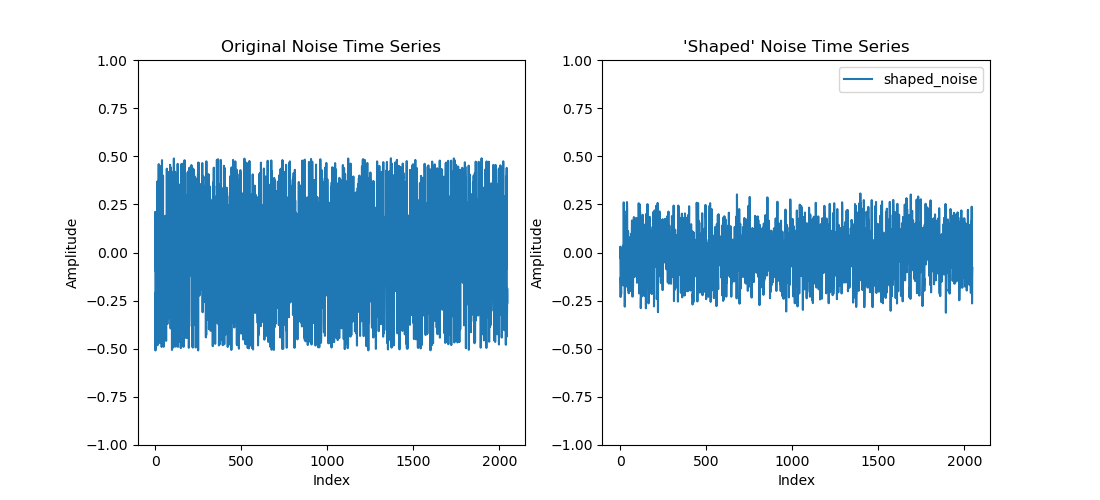

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(11,5))
ylims = [-1, 1]
axs[0].set_title("Original Noise Time Series")
axs[0].plot(noise, label="noise")
axs[0].set_ylim(ylims)
axs[1].set_title("'Shaped' Noise Time Series")
axs[1].plot(shaped_noise, label="shaped_noise")
axs[1].set_ylim(ylims)
plt.legend()
axs[0].set_xlabel("Index")
axs[1].set_xlabel("Index")
axs[0].set_ylabel("Amplitude")
axs[1].set_ylabel("Amplitude")

Figure  **1 Noise and Shaped Noise**: The original noise time series, and the filtered version

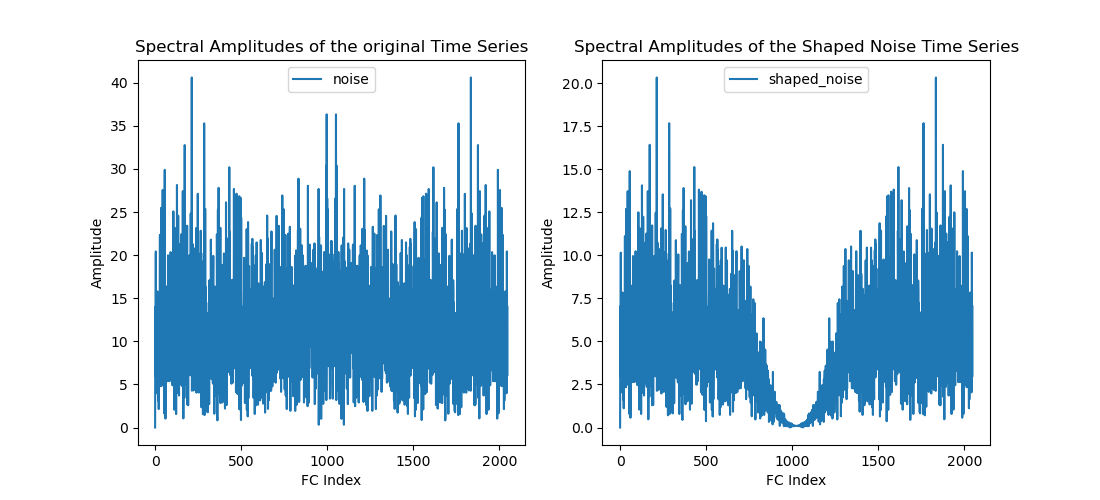

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(11,5))
axs[0].set_title("Spectral Amplitudes of the original Time Series")
axs[0].plot(np.abs(noise_spec), label="noise")
axs[0].set_xlabel("FC Index")
axs[0].set_ylabel("Amplitude")
#axs[0].set_ylim(ylims)
axs[1].set_title("Spectral Amplitudes of the Shaped Noise Time Series")
axs[1].plot(np.abs(shaped_noise_spec), label="shaped_noise")
axs[1].set_xlabel("FC Index")
axs[1].set_ylabel("Amplitude")
#axs[1].set_ylim(ylims)
axs[0].legend()
axs[1].legend()


Figure  **2 Noise and Shaped Spectra**: The original noise time series, and the filtered version

## Define the ARMA model order that will be used to fit the shaped noise

In [10]:
print(f"Shaping AR order = {ar_order}")
print(f"Shaping MA order = {ma_order}")

Shaping AR order = 2
Shaping MA order = 3


## Caution!!!

There is a bug here, I am overwritng the intended ARMA model order with a hard-coded MA(2) which works fine, but is not what I had intended.
In case_id==4 this gives an unstable ARMA which causes infinity in the lfilter results of I set (ARMA(2,3)), instead of MA(2).

In [11]:
ar_model_order = 0 #0
ma_model_order = 2 #2

In [12]:
arma_model = ARIMA(shaped_noise, order=(ar_model_order, 0, ma_model_order), trend="n")
print(f"arma_model.data.param_names {arma_model.data.param_names}")

arma_model.data.param_names None


In [13]:
arma_results = arma_model.fit()
arma_residual = arma_results.resid
arma_predicted = arma_results.predict()
residual2 = shaped_noise - arma_predicted
assert not (arma_residual-residual2).all()
print(f"MA params {arma_results.maparams}")
print(f"AR params {arma_results.arparams}")

MA params [ 0.83739675 -0.16255361]
AR params []


In [14]:
arma_results.params

array([ 0.83739675, -0.16255361,  0.00837312])

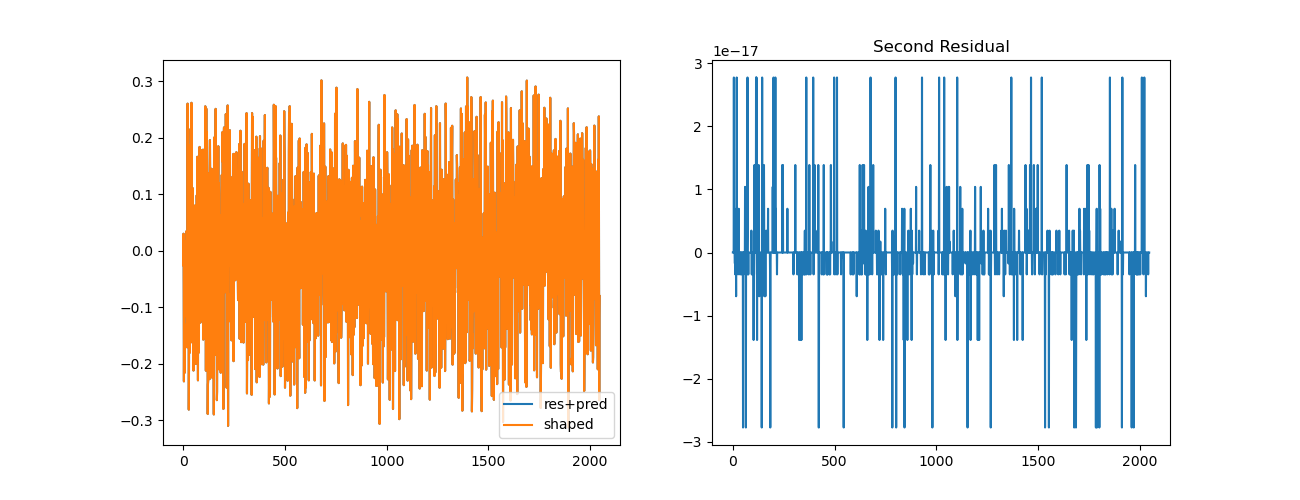

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(13,5))
axs[0].plot(arma_residual + arma_predicted, label="res+pred")
axs[0].plot(shaped_noise, label="shaped")
axs[1].plot((arma_residual + arma_predicted) - shaped_noise)
axs[1].set_title("Second Residual")
axs[0].legend()

Figure **X** The shaped noise equals the predicted values plus the residual.  Thus we have decomposed the input signal into the ARMA model predicted values and a residual.

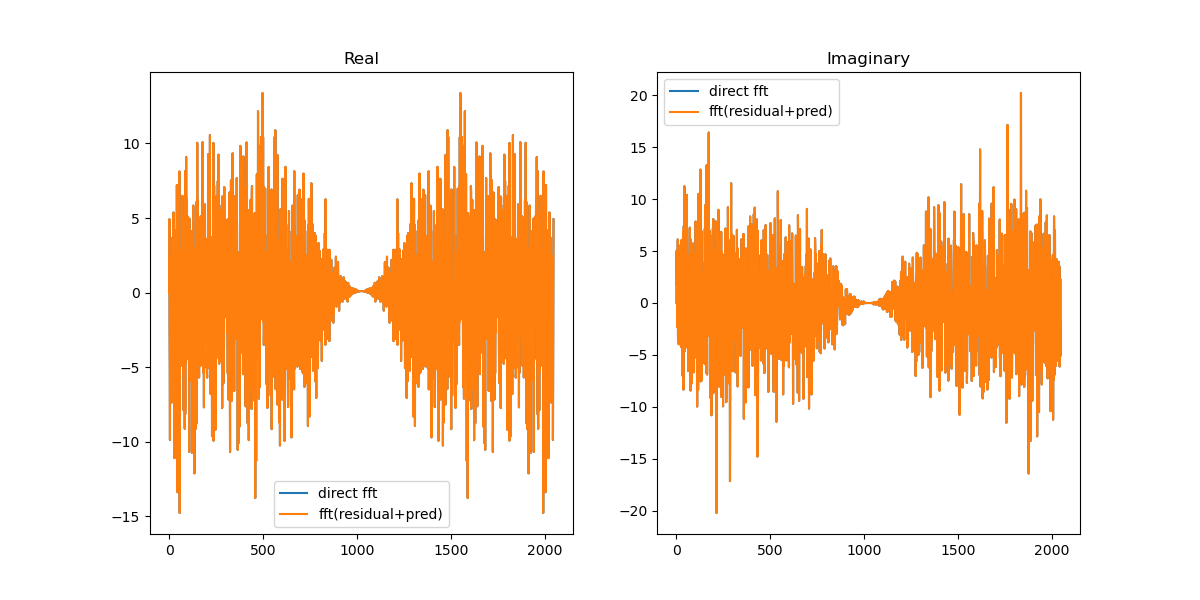

In [16]:
fft_shaped_noise = np.fft.fft(shaped_noise)
fft_residual = np.fft.fft(arma_results.resid)
fft_pred = np.fft.fft(arma_predicted)
compare_real_and_imaginary(fft_shaped_noise, fft_residual+fft_pred, label1="direct fft", label2="fft(residual+pred)")

Figure **XX** Shows a sanity check that the FFT(shaped_noise) is pretty much identical to that of (res+pred)

###  How is the "predicted" data being calculated

It is being done in a way that is _very_ similar to ssig.lfilter, however, not always exactly, and the code in statsmodels is pretty opaque about this ... 
https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.predict.html#statsmodels.tsa.arima.model.ARIMA.predict

I tried following a few threads on this:
https://stats.stackexchange.com/questions/453853/what-is-the-exact-defenition-of-arma-model-in-statsmodels-and-how-to-predict-the
https://stackoverflow.com/questions/67236144/how-does-statsmodels-calculate-in-sample-predictions-in-ar-models

But I cannot see why 
1. Statsmodels  is different form lfilter at the start of the time seies, but not later
2. There is an offset having to do (i think) with the difference in AR and MA orders

In [17]:
# Add a 1 to the front of the sequence of AR parameters
ma = np.array(arma_results.maparams)
ar = np.hstack((np.ones(1), np.array(arma_results.arparams)))
lfilter_result = ssig.lfilter(ma, ar, arma_residual)


In [18]:
lfilter_result

array([-0.02143534,  0.03818794, -0.08365373, ..., -0.10436102,
        0.01569669, -0.07853111])

In [19]:
# zi = ssig.lfilter_zi(ma, ar)
# lfilter_result2 = ssig.lfilter(np.array(arma_res.maparams), ar, residual, zi=zi)
# lfilter_result2
# fig, ax = plt.subplots(figsize=(13, 5))
# ax.plot(lfilter_result-lfilter_result2[0])
# #ax.plot(lfilter_result2[0])

# zi

# # resres = np.hstack((residual, residual))
# # lfilter_result2 = ssig.lfilter(np.array(arma_res.maparams), ar, resres)
# # fig, ax = plt.subplots(figsize=(13, 5))
# # ax.plot(np.hstack((lfilter_result, lfilter_result))-lfilter_result2)


In [20]:
print(f"len predicted = {len(arma_predicted)}")
print(f"len lfilter_result = {len(lfilter_result)}")

len predicted = 2048
len lfilter_result = 2048


### Plot arma predicted and lfilter result, note they are similar but shifted

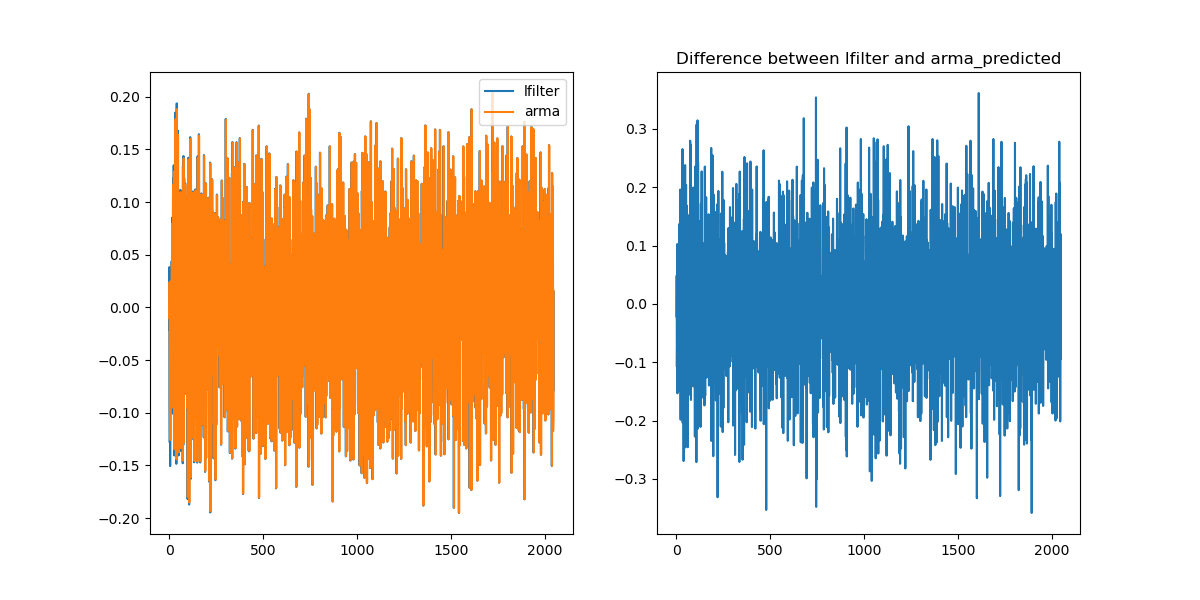

In [21]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
ax[0].plot(lfilter_result, label="lfilter")
ax[0].plot(arma_predicted, label="arma")
tsa_vs_lfilter_residual = lfilter_result-arma_predicted
ax[1].plot(lfilter_result-arma_predicted, label="res")
ax[1].set_title("Difference between lfilter and arma_predicted")
ax[0].legend()
# ax[0].set_xlim([0, 1900])
# ax[0].set_ylim([0, 10])
#ax.legend()

Figure **XX**: The predicted data and the "lfiltered" residual noise. 

There is an offset between the arma and lfilter plots.  This offset results in a large residual when the series' are subtracted.  I cannot explain this, except that there is a minor difference in the implementation of the filter between statsmodels and scipy.signal.

However, to first order, in this simple example, we have the predicted data "equal" to the MA filtered data.

### there is an off-by-one to sort out still here

It is at this point in the code that I was using a "fudge factor" called "offset".  The offset changeswith the order fo the filter.

since the statsmodels arma prediction and the lfilter results both had the same length (equal to the length of the original ts) 
but the statsmodels data wound up lagging the lfilter results by a single sample (in the case MA=2, AR=0)

THis got mode confusing as the factor seemed to change depending on the individual orders of the AR and MA parts of the model.

I wound up realizing that this offset was the reason I was seeing strange artefacts in the residuals between the lfilter spectra and the statsmodels spectra.



We can compute the offset however

Offset = 1


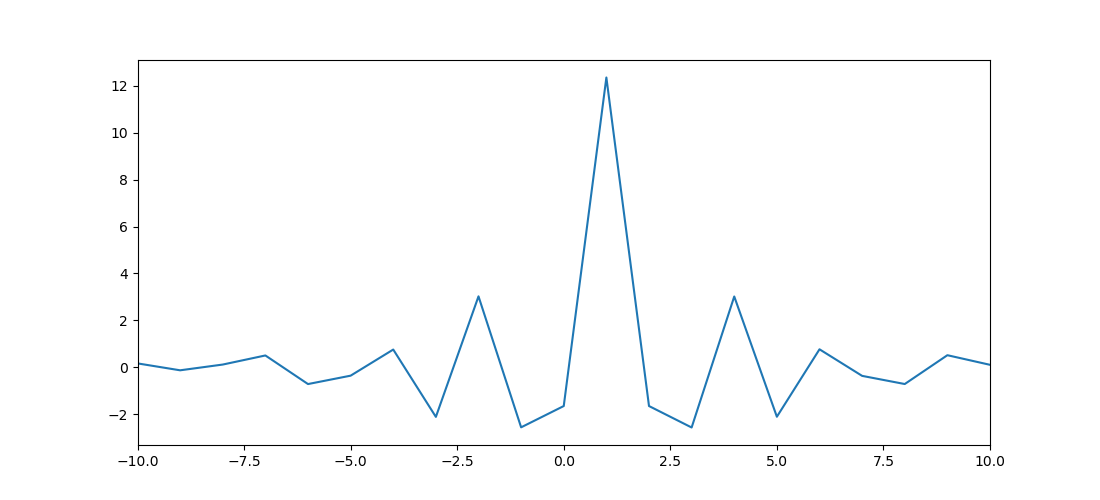

In [22]:
corr = ssig.correlate(arma_predicted, lfilter_result)
lags = ssig.correlation_lags(N, N)
fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(lags, corr)
ax.set_xlim(-10, 10)
print(f"Offset = {lags[np.argmax(corr)]}")
#ax.plot(lfilter_result2[0])


Figure **Correlate**:

REcall that the correlation of f with g (corr(f, g)) corresponds to g moving from right to left through f, and equivalently to f moving left to right through g.

A corr(pred, lfilter) maximum at 1 means that
pred(t) * lfilter(t+1) 
or 
pred(t-1) * lfiler(t) is max

Which says we need to either shift lfilter left by 1 or pred right by 1.

Shifting lfilter left by 1 is like advancing the time for lfilter

Shifting pred right is like retarding the time for pred


In [23]:
offset = lags[np.argmax(corr)]

## Apply offset correction

If we want to shift lfilter then we need to 

In [24]:
frq = np.fft.fftfreq(N)
shift1 = np.exp(complex(0,1)*frq*2*np.pi*offset)

In [25]:
arma_predicted_w_shift = np.fft.ifft(shift1 * np.fft.fft(arma_predicted))
arma_predicted_w_shift = np.real(arma_predicted_w_shift)

#and we will need later the shifted residual as well
arma_residual_w_shift = np.fft.ifft(shift1 * np.fft.fft(arma_residual))
arma_residual_w_shift = np.real(arma_residual_w_shift)

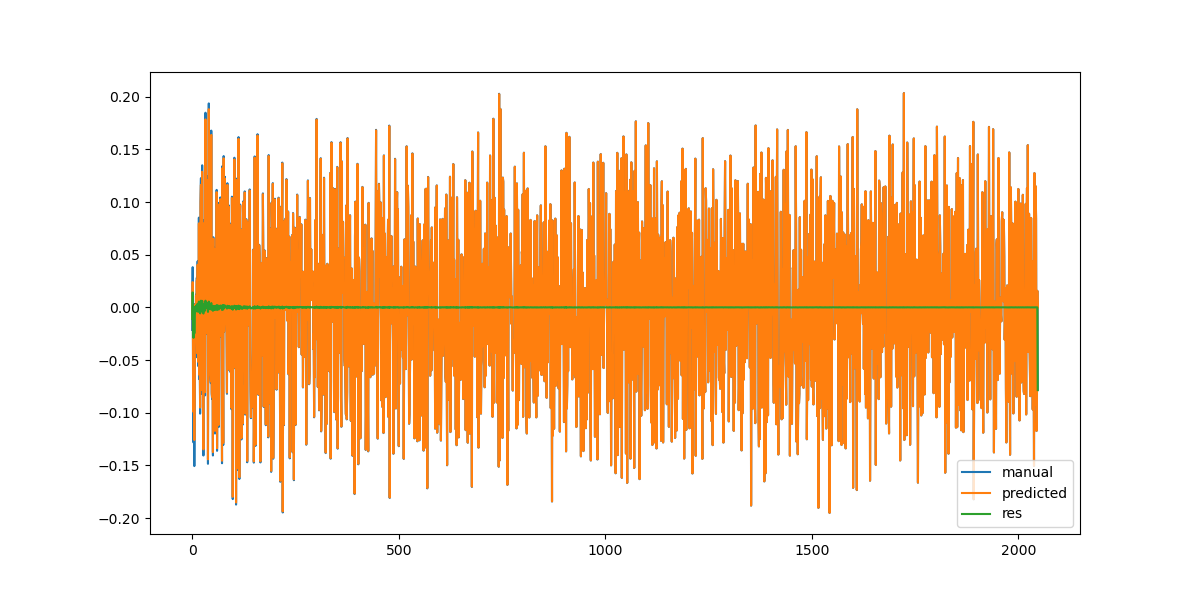

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
manual_prediction = lfilter_result
#? could this offset be a phase mulitplier??, exp(i*dt)?
tsa_prediction = arma_predicted_w_shift 
ax.plot(manual_prediction, label="manual")
ax.plot(tsa_prediction, label="predicted")
tsa_vs_manual_residual = manual_prediction-tsa_prediction
ax.plot(tsa_vs_manual_residual, label="res")
ax.legend()
ax.legend()

In [27]:
lfilter_w_shift = np.fft.ifft(shift1**-1 * np.fft.fft(lfilter_result))
lfilter_w_shift = np.real(lfilter_w_shift)

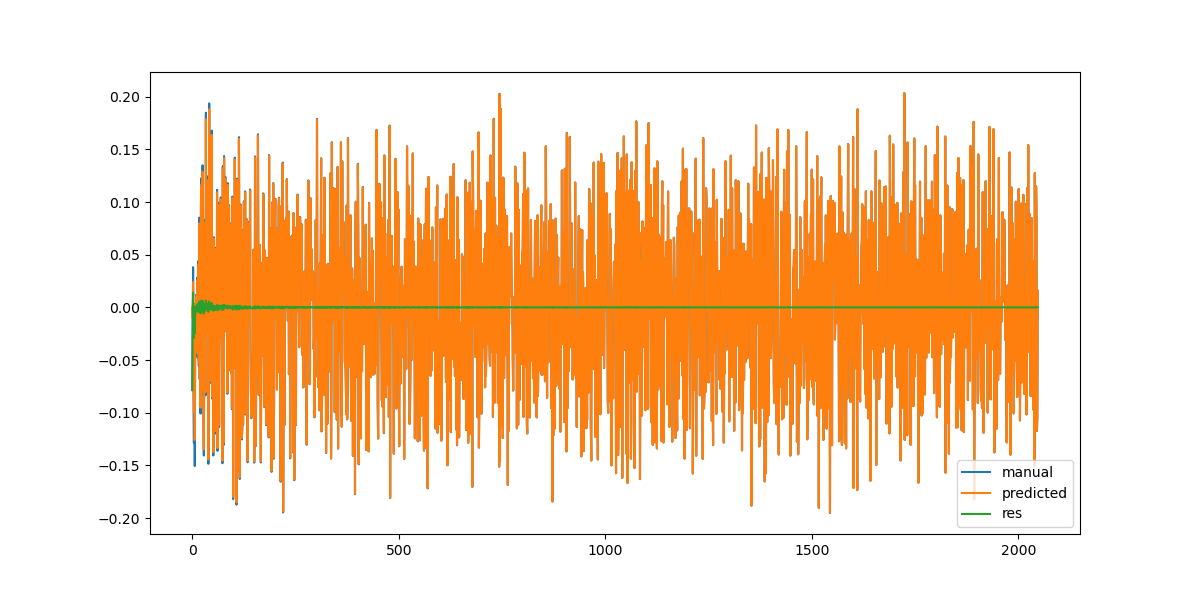

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
manual_prediction = lfilter_w_shift
tsa_prediction = arma_predicted 
ax.plot(manual_prediction, label="manual")
ax.plot(tsa_prediction, label="predicted")
tsa_vs_manual_residual = manual_prediction-tsa_prediction
ax.plot(tsa_vs_manual_residual, label="res")
ax.legend()
ax.legend()

Figure **XX**: The predicted data and the filtered residual noise. 

Note that the misfit is concentrated at the start of the series, and I am not sure why.  

However, to first order, in this simple example, we have the predicted data "equal" to the MA filtered data.

OK, so what has been done here, is that we have decomposed the shaped noise into an MA process on e(t) (the residual) and the residual itself.

That means that if we can express the filtering operation as a frequency domain multiplication, then we can apply the filter on the other side...

In [29]:
#? what are these guys?
arma_results.maroots

array([-1.00004269,  6.15155382])

Lets take a look at the frequency response of the MA filter

In [30]:
ma_series = np.hstack((arma_results.maparams, np.zeros(N-len(arma_results.maparams))))
ma_frequency_response = np.fft.fft(ma_series)
w, h = ssig.freqz(arma_results.maparams, ar, whole=True, worN=N)
#h = np.fft.fftshift(h)

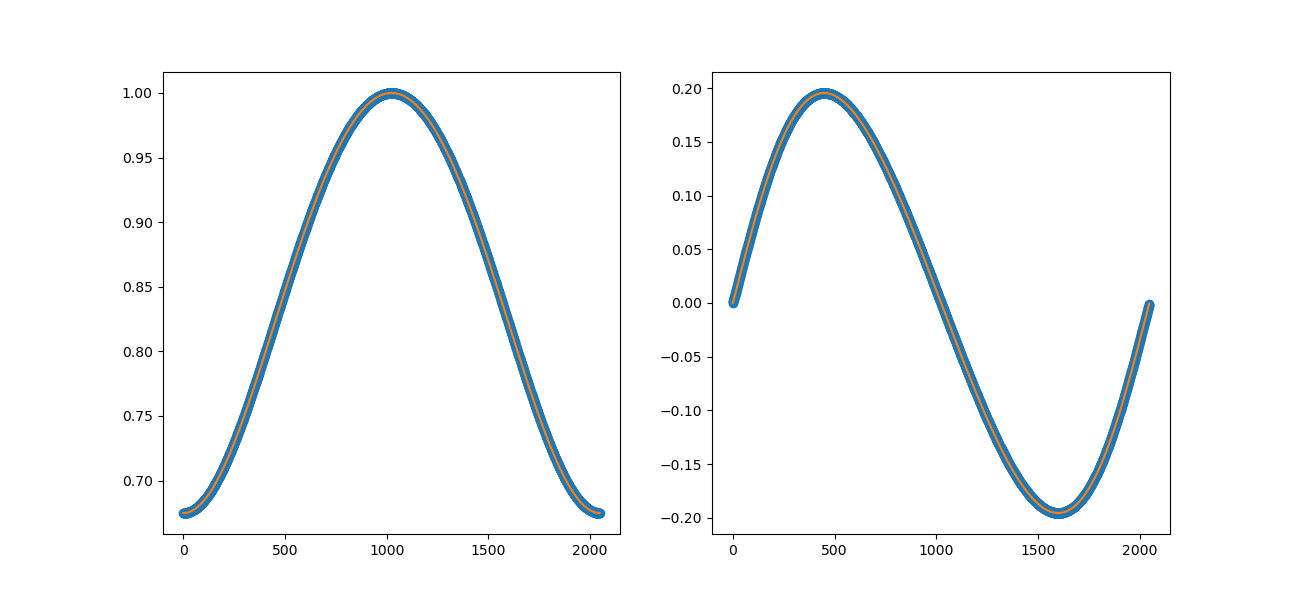

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(13, 6))
axs[0].plot(np.abs(h), 'o',label="hh")
axs[0].plot(np.abs(ma_frequency_response),  label="fft")
axs[1].plot(np.angle(h), 'o',label="hh")
axs[1].plot(np.angle(ma_frequency_response),  label="fft")



And real, and imaginary

In [32]:
#compare_real_and_imaginary(h, ma_frequency_response, "h", "fft")

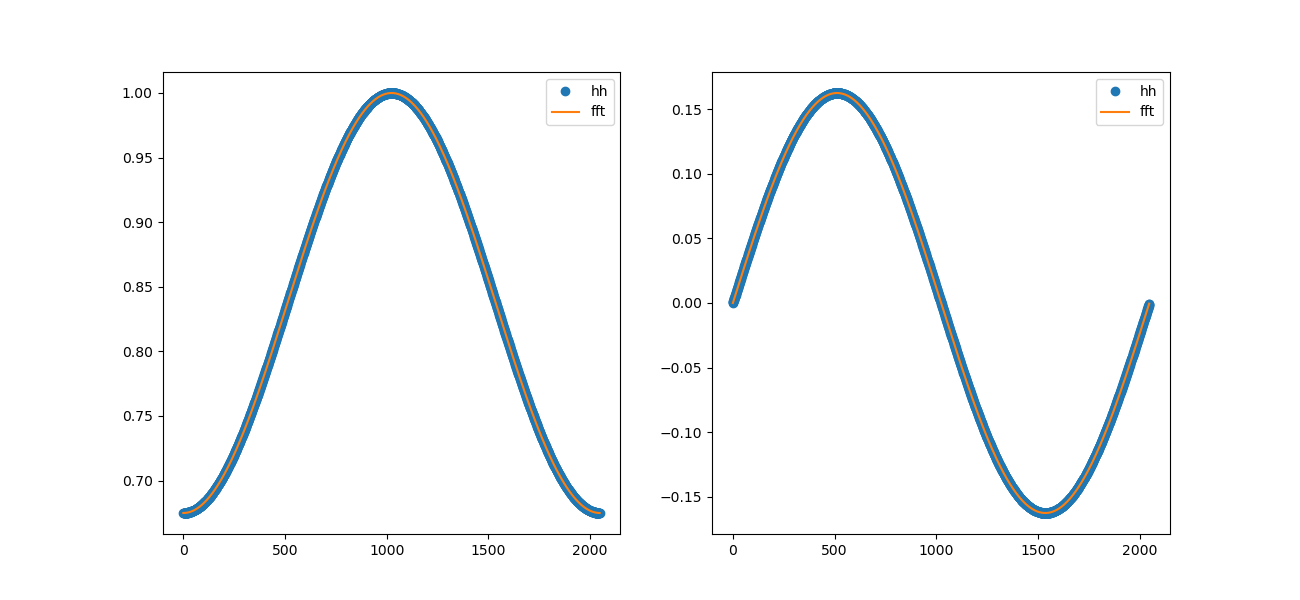

In [33]:
fig, axs = plt.subplots(ncols=2, figsize=(13, 6))
axs[0].plot(np.real(h), 'o',label="hh")
axs[0].plot(np.real(ma_frequency_response),  label="fft")
axs[0].legend()
axs[1].plot(np.imag(h), 'o',label="hh")
axs[1].plot(np.imag(ma_frequency_response),  label="fft")
axs[1].legend()

So, that means that we can FFT shaped_noise $y(t)$ without leakage, by using the following decompostion:

$y(t) = MA \ast res + res$

$F(y) = F(MA)  F(res) + F(res)$

### Let's see how well we can approximate the spectrum of the predicted data 

from 

In [34]:
fft_pred = np.fft.fft(arma_predicted_w_shift)
fft_res = np.fft.fft(arma_residual)
fft_MA = h# ma_frequency_response
fft_MAres = fft_res * fft_MA 


Text(0.5, 1.0, 'Imaginary')

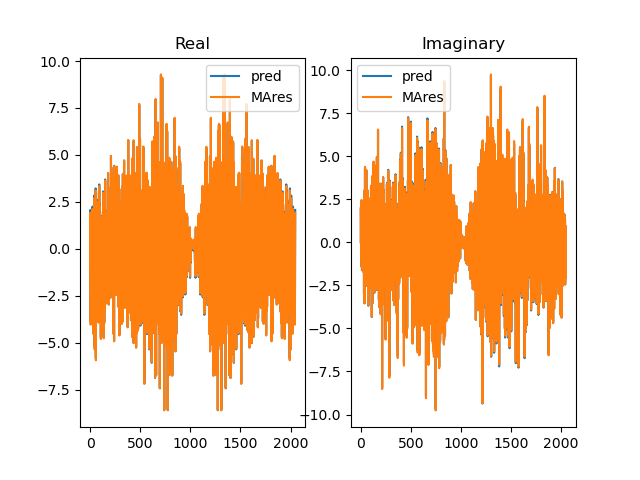

In [35]:
fig, axs = plt.subplots(ncols=2)
axs[0].plot(np.real(fft_pred), label="pred")
axs[0].plot(np.real(fft_MAres),  label="MAres")
axs[0].legend()
axs[0].set_title("Real")
axs[1].plot(np.imag(fft_pred), label="pred")
axs[1].plot(np.imag(fft_MAres),  label="MAres")
axs[1].legend()
axs[1].set_title("Imaginary")

Text(0.5, 1.0, 'Phase')

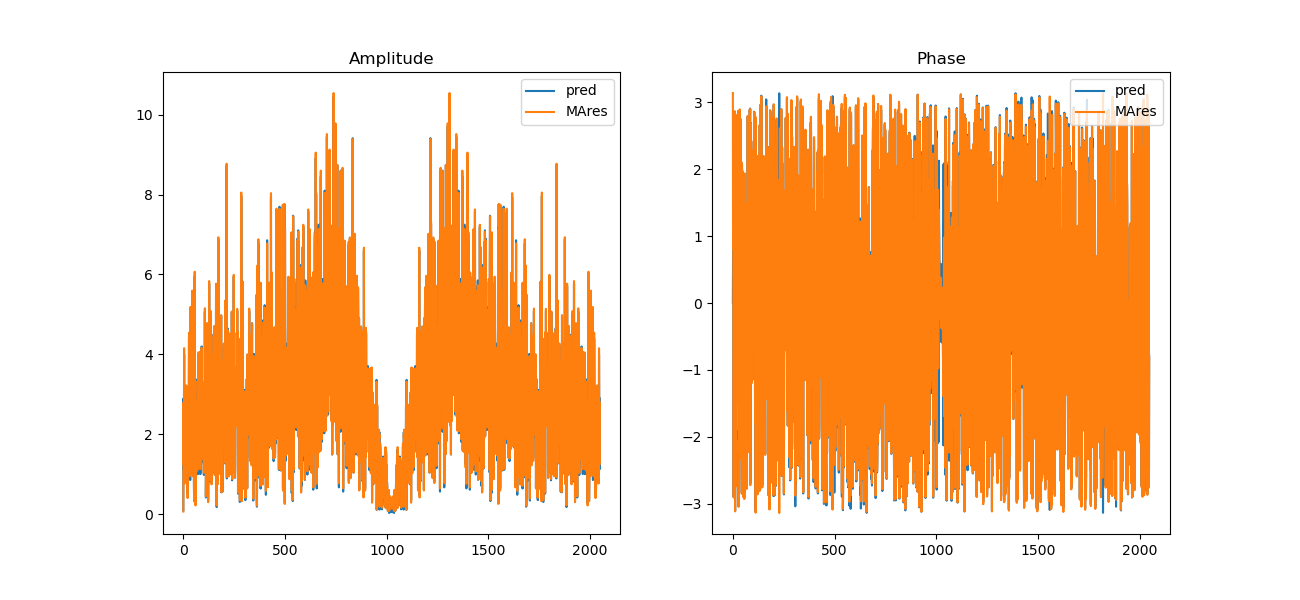

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(13,6))
axs[0].plot(np.abs(fft_pred), label="pred")
axs[0].plot(np.abs(fft_MAres),  label="MAres")
axs[0].legend()
axs[0].set_title("Amplitude")
axs[1].plot(np.angle(fft_pred), label="pred")
axs[1].plot(np.angle(fft_MAres),  label="MAres")
axs[1].legend()
axs[1].set_title("Phase")

Figure **XX** The amplitude responses of the two representations are practically identical, as expected

What we really want however is an approximation of the spectrum of shaped noise, that only ffts the arma residual

To get this we fft arma_residual, and add its spectrum to the filter

In [37]:
fft_shaped = np.fft.fft(shaped_noise)
#fft_MA = ma_frequency_response
fft_MA = h * shift1
fft_shaped2 = (fft_MA*fft_res) + fft_res

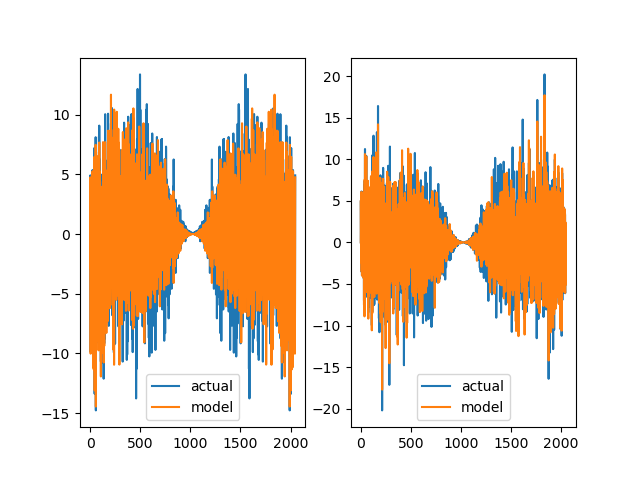

In [38]:
fig, axs = plt.subplots(ncols=2)
axs[0].plot(np.real(fft_shaped), label="actual")
axs[0].plot(np.real(fft_shaped2),  label="model")
axs[0].legend()
axs[1].plot(np.imag(fft_shaped), label="actual")
axs[1].plot(np.imag(fft_shaped2),  label="model")
axs[1].legend()

Text(0.5, 1.0, 'Phase')

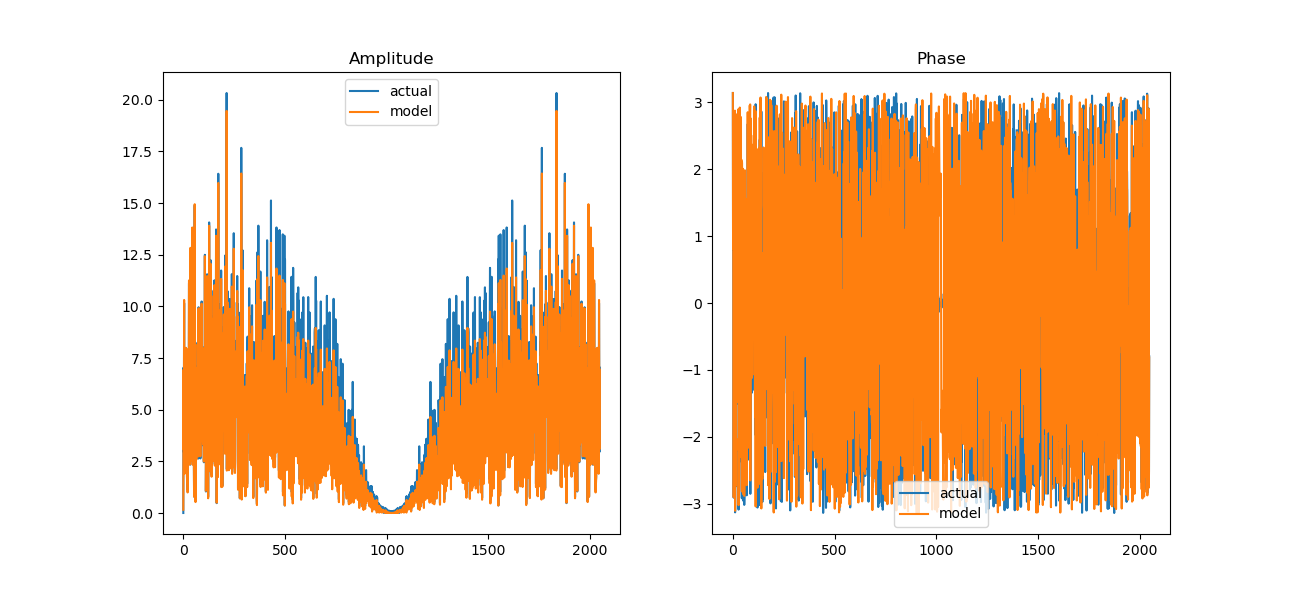

In [39]:
fig, axs = plt.subplots(ncols=2, figsize=(13,6))
axs[0].plot(np.abs(fft_shaped), label="actual")
axs[0].plot(np.abs(fft_shaped2),  label="model")
axs[0].legend()
axs[0].set_title("Amplitude")
axs[1].plot(np.angle(fft_shaped), label="actual")
axs[1].plot(np.angle(fft_shaped2),  label="model")
axs[1].legend()
axs[1].set_title("Phase")